In [25]:
! pip install tqdm, pygame, pytorchvision


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [86]:
import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T

from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym

from collections import deque
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

In [125]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        # self.linear2 = nn.Linear(in_features=300, out_features=600)
        self.linear3 = nn.Linear(in_features=128, out_features=output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        x = self.linear3(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        # self.linear2 = nn.Linear(in_features=300, out_features=600)
        self.linear3 = nn.Linear(in_features=128, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        output = self.linear3(x)
        return output

In [137]:


class ActorCritic():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 5000
      self.max_steps = 1000
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 120
      self.replay_buffer_capacity=5000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      # _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.actor = Actor(self.state_count, self.action_count)
      self.critic = Critic(self.state_count, 1)#self.action_count) 
      # self.critic_av = Critic(self.state_count, self.action_count) 
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
      self.loss_func = F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./actor.pth"
    
    def choose_action(self, state, test=False):
      if not test:
          action_prob = self.actor(state)
          actions_cat = Categorical(action_prob)

          current_action = actions_cat.sample()
          action_log_prob = actions_cat.log_prob(current_action)
          return current_action, action_log_prob
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.actor(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.actor.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) 
        while not done:
          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 

          steps +=1
          
          current_state = next_state
          if steps==500 or reward_sum==470:
            done=True

        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self, current_state, reward, next_state, done, action_log_prob, I):
      
      current_state_val = self.critic(current_state)
      next_state_val = self.critic(next_state) if not done else 0
  
      delta = reward + self.gamma*next_state_val - current_state_val
      actor_loss = (-1*action_log_prob*delta.item()*I)
      critic_loss = (delta**2)
      # print(actor_loss, critic_loss)
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      
      # (actor_loss + critic_loss).backward()
      actor_loss.backward()
      critic_loss.backward()
      for param in self.actor.parameters():
          param.grad.data.clamp_(-1, 1)
      for param in self.critic.parameters():
          param.grad.data.clamp_(-1, 1)
      
      self.actor_optimizer.step()
      self.critic_optimizer.step()

      return actor_loss.item(), critic_loss.item()
      
    def learn(self):
      
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        a_running_loss=0
        c_running_loss=0
        I = 1
        current_state = torch.from_numpy(obs).unsqueeze(0)
        while not done:
          current_action, action_log_prob = self.choose_action(current_state)

          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward
          
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 
  
          actor_loss, critic_loss = self.train(current_state, curr_reward, next_state, done, action_log_prob, I)
          I = self.gamma*I
          steps +=1
          # print(actor_loss,critic_loss)
          a_running_loss += actor_loss
          c_running_loss += critic_loss
          current_state = next_state

          if steps==self.max_steps:# or reward_sum==470:
            done=True

        # self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          # print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | loss: {a_running_loss / 10:.3f}, {c_running_loss / 10:.3f}')
          a_running_loss = 0.0
          c_running_loss = 0.0
          self.env.render()
          if sum(self.rewards_list[-100:])/100 >= 200:
            break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.critic.load_state_dict(self.actor.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)



In [138]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset()
agent = ActorCritic(env)
agent.learn()

  2%|▏         | 100/5000 [02:43<2:25:02,  1.78s/episodes]

[Episode: 100] - Steps: 251.28 | Rewards: -66.77169093303577 | loss: -0.235, 8666.155


  4%|▍         | 200/5000 [05:33<5:20:27,  4.01s/episodes]

[Episode: 200] - Steps: 187.19 | Rewards: -20.621980174767415 | loss: -0.644, 2664.070


  6%|▌         | 300/5000 [07:28<1:05:39,  1.19episodes/s]

[Episode: 300] - Steps: 206.86 | Rewards: -44.264899767333766 | loss: -4.741, 4540.034


  8%|▊         | 400/5000 [10:20<58:50,  1.30episodes/s]  

[Episode: 400] - Steps: 324.34 | Rewards: -21.11310363731697 | loss: -0.032, 2097.022


  9%|▊         | 428/5000 [11:09<3:35:20,  2.83s/episodes]

In [21]:
PATH = './actor.pth'
torch.save(agent.actor.state_dict(), PATH)

In [22]:
PATH = './critic.pth'
torch.save(agent.critic.state_dict(), PATH)

In [134]:
epsilon_list_train_dqn = agent.epsilon_list[:4800]
reward_list_train_dqn = agent.rewards_list[:4800]

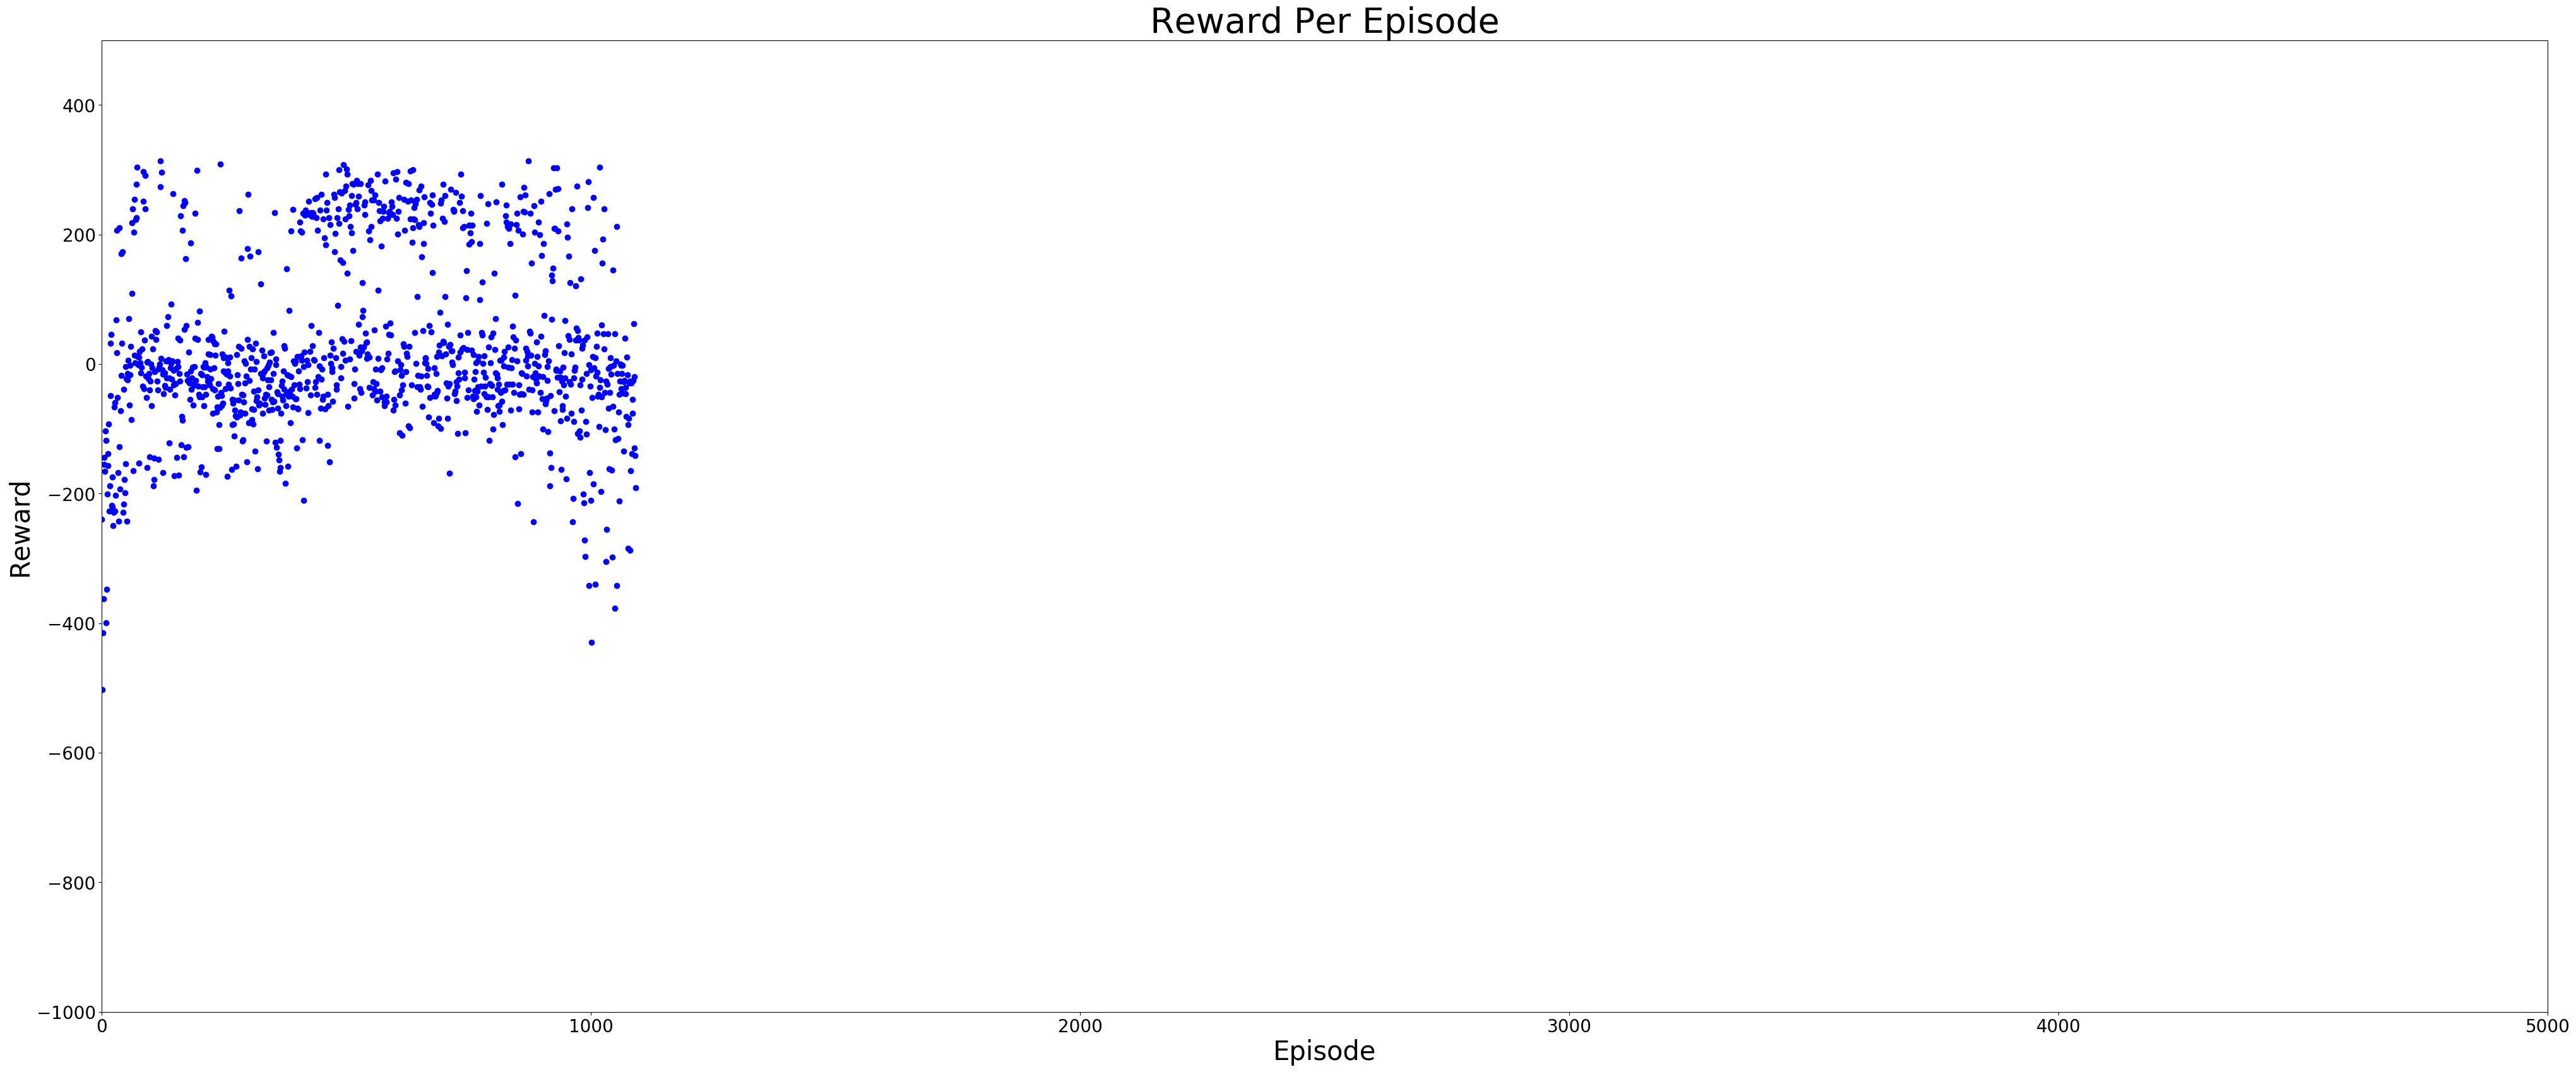

In [131]:
fig, (ax2) = plt.subplots(1,1)
fig.set_figheight(20)
fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=5000)
ax2.set_ylim(ymin=-1000, ymax=500)
plt.show()

In [135]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 48):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))


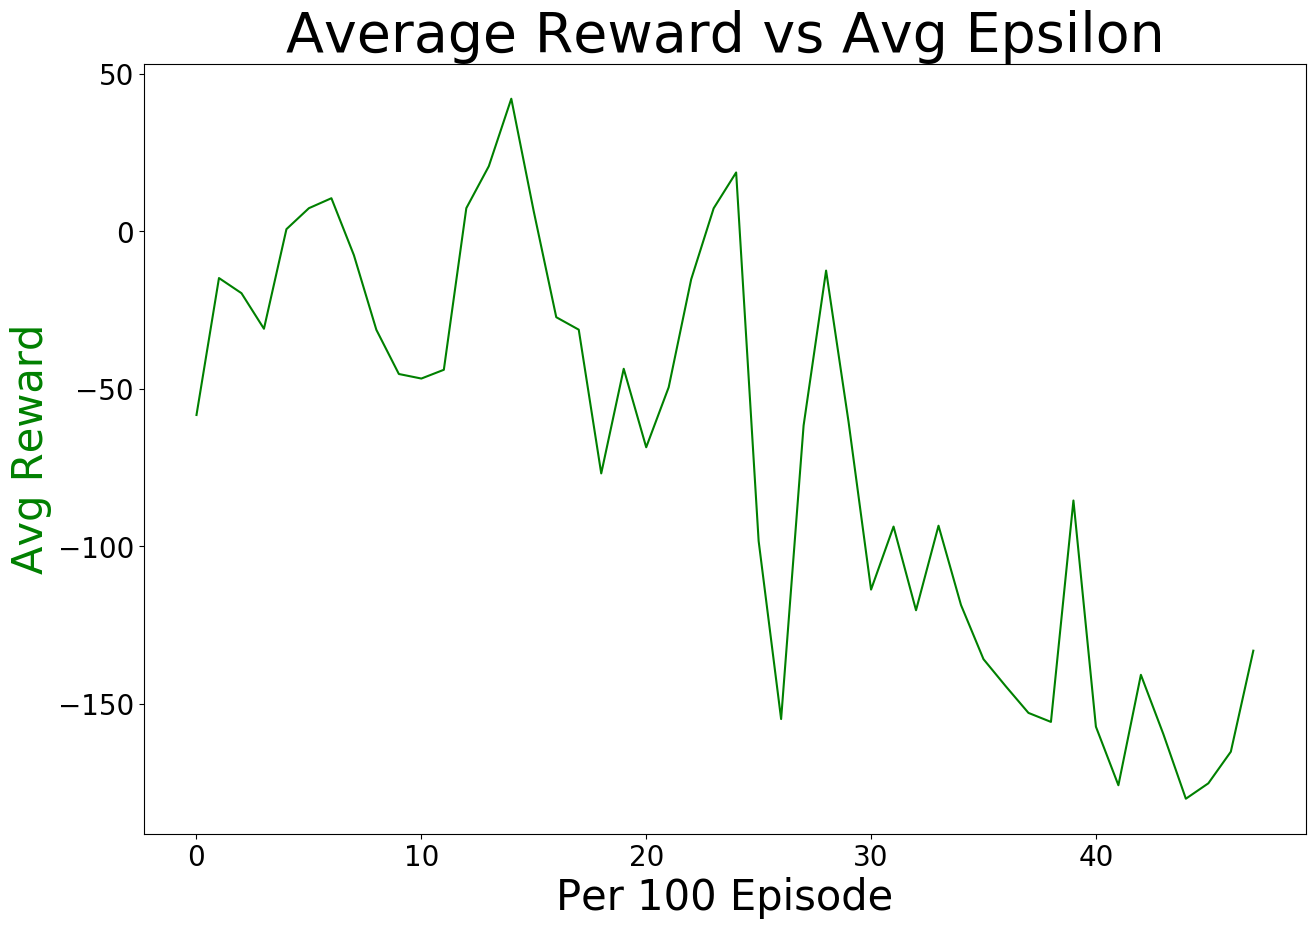

In [136]:
fig, ax2 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax2.set_title("Average Reward vs Avg Epsilon", size=40)
ax2.set_xlabel('Per 100 Episode', fontsize=30)
ax2.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [ ]:
import json
with open('reward.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

# import json
# with open('backup/epsilon.json') as f:
#     epsilon_list_train_dqn = json.load(f)

In [4]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
agent_test = CartPoleVanillaDQN(env)
agent_test.eval()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 10/10 [00:22<00:00,  2.20s/episodes]


In [6]:
reward_list_test_dqn = agent_test.test_rewards_list

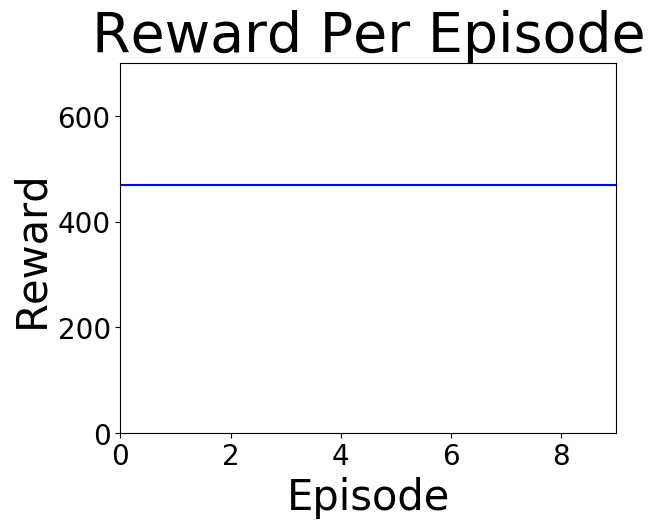

In [12]:
fig, (ax2) = plt.subplots(1,1)
# fig.set_figheight(50)
# fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_test_dqn, 'b-')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=9)
ax2.set_ylim(ymin=0, ymax=700)
plt.show()